In [1]:
import os
import json
import math

# ! pip install seaborn
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import seaborn as sn

from tqdm import tqdm
import glob

from PIL import Image
from sklearn.metrics import f1_score

from skimage import morphology, color

import torch
from torch import nn, optim
from torchvision.datasets import ImageFolder
from torch.utils.data import Dataset, random_split
from torchvision.transforms import transforms
from torch.utils.data import DataLoader, Dataset, SubsetRandomSampler

from transformers import (TrOCRProcessor, 
                        TrOCRForCausalLM, 
                        VisionEncoderDecoderModel, 
                        ViTFeatureExtractor, 
                        ViTForImageClassification)

from utils.utils import *

In [2]:
dataset_path = "data/all_preprocessed_data/"

# Create a custom ToRGB transform
class ToRGB(object):
    def __call__(self, image):
        return image.convert('RGB')

# Transforms pipeline for train and validation data loaders
preprocess = transforms.Compose([
    transforms.Resize([100, ]),
    transforms.Lambda(
        lambda img: pad(img, padding=(0, 0, max(0, 200 - img.width), max(0, 100 - img.height)), 
                                              fill=(255, 255, 255))),
    transforms.CenterCrop((100, 200)),
    ToRGB(),
#   (erosion followed by !dilation is operated on the grayscale image)
#     PartialErosion(iterations=2),
#     transforms.ToTensor(),

#     transforms.Grayscale(num_output_channels=3),
#     transforms.Grayscale(),
#     transforms.Normalize([0.5], [0.5])
#     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
#     transforms.ToPILImage()
])

# Load the entire dataset (since we don't have a train and validation split in the )
# dataset = ImageFolder(dataset_path, transform=preprocess)

In [19]:
# Initialize the model and processor
# processor = TrOCRProcessor.from_pretrained("microsoft/trocr-base-handwritten")
# model = VisionEncoderDecoderModel.from_pretrained("microsoft/trocr-base-handwritten")

processor = TrOCRProcessor.from_pretrained('microsoft/trocr-large-stage1')
model = VisionEncoderDecoderModel.from_pretrained('microsoft/trocr-large-stage1')

# processor = ViTFeatureExtractor.from_pretrained('google/vit-base-patch16-224')
# model = ViTForImageClassification.from_pretrained('google/vit-base-patch16-224')

# Freeze TrOCR layers
for param in model.parameters():
    param.requires_grad = False

Some weights of VisionEncoderDecoderModel were not initialized from the model checkpoint at microsoft/trocr-large-stage1 and are newly initialized: ['encoder.pooler.dense.bias', 'encoder.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [4]:
# 32 * (577 // 8) * (768 // 8)
# 32 * (577 // 8) * (1024 // 8)

In [4]:
# Define your classifier
classifier = nn.Sequential(
    
    nn.Conv2d(1, 16, kernel_size=1, stride=1),
    nn.ReLU(inplace=True),
    nn.MaxPool2d(2, 2),
    nn.Conv2d(16, 32, kernel_size=1, stride=1),
    nn.ReLU(inplace=True),
    nn.MaxPool2d(2, 2),
    nn.Conv2d(32, 32, kernel_size=1, stride=1),
    nn.ReLU(inplace=True),
    nn.MaxPool2d(2, 2),
    nn.Flatten(),
    nn.Linear(32 * (577 // 8) * (1024 // 8), 512),
    nn.ReLU(inplace=True),
    nn.Linear(512, 512),
    nn.ReLU(inplace=True),
    nn.Dropout(0.2),
    nn.Linear(512, 256),
#     nn.Dropout(0.2),
    nn.ReLU(inplace=True),
    nn.Linear(256, 1)
)

loss_function = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(classifier.parameters(), lr=0.003)

classifier

Sequential(
  (0): Conv2d(1, 16, kernel_size=(1, 1), stride=(1, 1))
  (1): ReLU(inplace=True)
  (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (3): Conv2d(16, 32, kernel_size=(1, 1), stride=(1, 1))
  (4): ReLU(inplace=True)
  (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (6): Conv2d(32, 32, kernel_size=(1, 1), stride=(1, 1))
  (7): ReLU(inplace=True)
  (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (9): Flatten(start_dim=1, end_dim=-1)
  (10): Linear(in_features=294912, out_features=512, bias=True)
  (11): ReLU(inplace=True)
  (12): Linear(in_features=512, out_features=512, bias=True)
  (13): ReLU(inplace=True)
  (14): Dropout(p=0.2, inplace=False)
  (15): Linear(in_features=512, out_features=256, bias=True)
  (16): ReLU(inplace=True)
  (17): Linear(in_features=256, out_features=1, bias=True)
)

In [5]:
# Move the model to the device (CPU or GPU)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# device = torch.device('cpu')
device

device(type='cuda')

In [9]:
class MyImageFolder(ImageFolder):
    def __init__(self, root, processor, transform=None, target_transform=None):
        super().__init__(root, transform=transform, target_transform=target_transform)
        self.processor = processor

    def __getitem__(self, index):
        # We retrieve the image and label like in the default __getitem__ method
        img, target = super().__getitem__(index)

        # We apply the TrOCR processor to the image
        pixel_values = self.processor(images=img, return_tensors="pt").pixel_values

        # We return the tensor under the "pixel_values" key along with the target
        return pixel_values, target

In [10]:
dataset = MyImageFolder(dataset_path, processor)

In [16]:
# Define the split sizes
train_size = int(0.8 * len(dataset))  # 80% for training
val_size = len(dataset) - train_size  # 20% for validation

# Split the dataset
train_dataset, valid_dataset = random_split(dataset, [train_size, val_size])

# Create the DataLoaders
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False)

train_size, val_size

(357104, 89276)

In [18]:
list(range(torch.cuda.device_count()))

[0, 1]

In [20]:
# If there are multiple GPUs available, wrap the model with nn.DataParallel
if torch.cuda.device_count() > 1:
    print("Let's use", torch.cuda.device_count(), "GPUs!")
    model = torch.nn.DataParallel(model, list(range(torch.cuda.device_count())))

model.to(device)
# classifier = classifier.to(device)

Let's use 2 GPUs!


DataParallel(
  (module): VisionEncoderDecoderModel(
    (encoder): ViTModel(
      (embeddings): ViTEmbeddings(
        (patch_embeddings): ViTPatchEmbeddings(
          (projection): Conv2d(3, 1024, kernel_size=(16, 16), stride=(16, 16))
        )
        (dropout): Dropout(p=0.0, inplace=False)
      )
      (encoder): ViTEncoder(
        (layer): ModuleList(
          (0): ViTLayer(
            (attention): ViTAttention(
              (attention): ViTSelfAttention(
                (query): Linear(in_features=1024, out_features=1024, bias=False)
                (key): Linear(in_features=1024, out_features=1024, bias=False)
                (value): Linear(in_features=1024, out_features=1024, bias=False)
                (dropout): Dropout(p=0.0, inplace=False)
              )
              (output): ViTSelfOutput(
                (dense): Linear(in_features=1024, out_features=1024, bias=True)
                (dropout): Dropout(p=0.0, inplace=False)
              )
            )
      

In [ ]:
num_epochs = 1

# Loop to extract image representation and store the tensors 
# (this step is one-time as we are not training the TrOCR model)
for epoch in range(num_epochs):
    
    with tqdm(enumerate(train_loader), total=math.ceil(train_size/batch_size)) as pbar:
        
        for batch_idx, (pixel_values, labels) in pbar:
            pixel_values, labels = pixel_values.squeeze(1).to(device), labels.float().unsqueeze(1).to(device)
                        
            # The `encoder_outputs` variable will contain the intermediate output 
            # of the vision transformer part of the TrOCR model
            encoder_outputs = model.module.encoder(pixel_values)

            # This is the image representation
            image_representation = encoder_outputs.last_hidden_state
            # print(image_representation.shape)
            # image_representation = image_representation.mean(dim=1)  # shape will now be [32, 768]
            torch.save(image_representation.cpu(), f'tensors/train/train_image_representation_{epoch}_{batch_idx}.pt')
            torch.save(labels.cpu(), f'tensors/train/labels_{epoch}_{batch_idx}.pt')
    
    with torch.no_grad():
        with tqdm(enumerate(val_loader), total=math.ceil(val_size/batch_size)) as pbar:

            for batch_idx, (pixel_values, labels) in pbar:
                pixel_values, labels = pixel_values.squeeze(1).to(device), labels.float().unsqueeze(1).to(device)

                # The `encoder_outputs` variable will contain the intermediate output 
                # of the vision transformer part of the TrOCR model
                encoder_outputs = model.module.encoder(pixel_values)

                # This is the image representation
                image_representation = encoder_outputs.last_hidden_state
                # image_representation = image_representation.mean(dim=1)  # shape will now be [32, 768]
                torch.save(image_representation.cpu(), f'tensors/valid/val_image_representation_{epoch}_{batch_idx}.pt')
                torch.save(labels.cpu(), f'tensors/valid/labels_{epoch}_{batch_idx}.pt')

 31%|███       | 3454/11160 [1:32:35<3:23:39,  1.59s/it]

In [13]:
class TensorDataset(Dataset):
    def __init__(self, tensor_directory):
        self.tensor_files = glob.glob(f'{tensor_directory}/train*.pt')
        self.label_files = glob.glob(f'{tensor_directory}/labels*.pt')
        self.tensor_files.sort()  # make sure that the tensor files are in the correct order
        self.label_files.sort()  # make sure that the tensor files are in the correct order
        
    def __len__(self):
        return len(self.tensor_files)

    def __getitem__(self, idx):
        tensor_file = self.tensor_files[idx]
        lable_file = self.label_files[idx]
        tensor = torch.load(tensor_file)
        labels = torch.load(lable_file)
        
        return tensor, labels

train_tensor_directory = 'tensors/train'
train_dataset = TensorDataset(train_tensor_directory)
train_loader = DataLoader(train_dataset, batch_size=1, shuffle=False)

val_tensor_directory = 'tensors/valid'
val_dataset = TensorDataset(val_tensor_directory)
val_loader = DataLoader(val_dataset, batch_size=1, shuffle=False)

In [14]:
num_epochs = 15
best_val_loss = float('inf')
counter = 0

patience = 5

classifier = classifier.to(device)

# Training loop
for epoch in range(num_epochs):
    
    val_correct = 0
    train_correct = 0
    
    val_loss = 0
    train_loss = 0
    
    with tqdm(enumerate(train_loader), total=math.ceil(train_size/batch_size)) as pbar:
        
        for batch_idx, (image_representation, labels) in pbar:
            
            image_representation = image_representation.squeeze(0).unsqueeze(1)
            labels = labels.float().squeeze(0)
            image_representation, labels = image_representation.to(device), labels.to(device)
            
            optimizer.zero_grad()
            # Pass the image features through the classifier
            classifier_output = classifier(image_representation)
            loss = loss_function(classifier_output, labels)
            
            predictions = torch.round(torch.sigmoid(classifier_output))

            train_loss += loss.item()
            train_correct += (predictions == labels).sum().item()

            loss.backward()
            optimizer.step()
    
    
    classifier.eval()
    with torch.no_grad():
        with tqdm(enumerate(val_loader), total=math.ceil(val_size/batch_size)) as pbar:

            for batch_idx, (image_representation, labels) in pbar:
                
                image_representation = image_representation.squeeze(0).unsqueeze(1)
                labels = labels.float().squeeze(0)
                image_representation, labels = image_representation.to(device), labels.to(device)

                # Pass the image features through the classifier
                classifier_output = classifier(image_representation.squeeze(0).unsqueeze(1))
                loss = loss_function(classifier_output, labels)

                predictions = torch.round(torch.sigmoid(classifier_output))

                val_loss += loss.item()
                val_correct += (predictions == labels).sum().item()
    
    # Calculate average loss and accuracy
    train_loss /= train_size
    train_accuracy = train_correct / train_size

    val_loss /= val_size
    val_accuracy = val_correct / val_size
    
    print(f'Epoch [{epoch + 1}/{num_epochs}], \n'
        f'Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}, \n'
        f'Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy:.4f} \n'
        )
    
    # Save the best model based on validation loss and early stopping
    if val_loss <= best_val_loss:
        best_val_loss = val_loss
        counter = 0
        # Save the model
        print("Saving model...")
        torch.save(classifier.state_dict(), 'model/TrOCR_L_enc_feature_extraction_w_classifier.pth')
    else:
        counter += 1
        # Check if the counter reaches the patience limit
        if counter >= patience:
            print('Early stopping triggered...')
            break

  1%|          | 67/11160 [00:10<29:41,  6.23it/s] 


IndexError: list index out of range

In [11]:
num_epochs = 15
best_val_loss = float('inf')
counter = 0

patience = 5

# Training loop
for epoch in range(num_epochs):
    
    val_correct = 0
    train_correct = 0
    
    val_loss = 0
    train_loss = 0
    
    with tqdm(enumerate(train_loader), total=math.ceil(train_size/batch_size)) as pbar:
        
        for batch_idx, (pixel_values, labels) in pbar:
            pixel_values, labels = pixel_values.squeeze(1).to(device), labels.float().unsqueeze(1).to(device)
                        
            # The `encoder_outputs` variable will contain the intermediate output 
            # of the vision transformer part of the TrOCR model
            encoder_outputs = model.encoder(pixel_values)

            # This is the image representation
            image_representation = encoder_outputs.last_hidden_state
            # print(image_representation.shape)
            # image_representation = image_representation.mean(dim=1)  # shape will now be [32, 768]
            
            optimizer.zero_grad()
            # Pass the image features through the classifier
            classifier_output = classifier(image_representation.unsqueeze(1))
            loss = loss_function(classifier_output, labels)
            
            predictions = torch.round(torch.sigmoid(classifier_output)) # .squeeze(1)

            train_loss += loss.item()
            train_correct += (predictions == labels).sum().item()

            loss.backward()
            optimizer.step()
    
    
    classifier.eval()
    with torch.no_grad():
        with tqdm(enumerate(val_loader), total=math.ceil(val_size/batch_size)) as pbar:

            for batch_idx, (pixel_values, labels) in pbar:
                pixel_values, labels = pixel_values.squeeze(1).to(device), labels.float().unsqueeze(1).to(device)

                # The `encoder_outputs` variable will contain the intermediate output 
                # of the vision transformer part of the TrOCR model
                encoder_outputs = model.encoder(pixel_values)

                # This is the image representation
                image_representation = encoder_outputs.last_hidden_state
                # image_representation = image_representation.mean(dim=1)  # shape will now be [32, 768]

                # Pass the image features through the classifier
                classifier_output = classifier(image_representation.unsqueeze(1))
                loss = loss_function(classifier_output, labels)

                predictions = torch.round(torch.sigmoid(classifier_output)) # .squeeze(1)

                val_loss += loss.item()
                val_correct += (predictions == labels).sum().item()
    
    # Calculate average loss and accuracy
    train_loss /= train_size
    train_accuracy = train_correct / train_size

    val_loss /= val_size
    val_accuracy = val_correct / val_size
    
    print(f'Epoch [{epoch + 1}/{num_epochs}], \n'
        f'Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}, \n'
        f'Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy:.4f} \n'
        )
    
    # Save the best model based on validation loss and early stopping
    if val_loss <= best_val_loss:
        best_val_loss = val_loss
        counter = 0
        # Save the model
        print("Saving model...")
        torch.save(classifier.state_dict(), 'model/TrOCR_L_enc_feature_extraction_w_classifier.pth')
    else:
        counter += 1
        # Check if the counter reaches the patience limit
        if counter >= patience:
            print('Early stopping triggered...')
            break

 84%|████████▍ | 9411/11160 [3:41:55<41:16,  1.42s/it]  IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

 40%|████      | 4488/11160 [1:46:18<2:38:02,  1.42s/it]


KeyboardInterrupt: 

In [18]:
len(encoder_outputs[0][0])

577

In [ ]:
# torch.save(classifier.state_dict(), 'model/TrOCR_enc_feature_extraction_w_classifier.pth')

In [12]:
test_classifier = classifier

test_classifier.load_state_dict(torch.load("model/TrOCR_L_enc_feature_extraction_w_classifier.pth"))
test_classifier.to(device)

Sequential(
  (0): Conv2d(1, 16, kernel_size=(1, 1), stride=(1, 1))
  (1): ReLU(inplace=True)
  (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (3): Conv2d(16, 32, kernel_size=(1, 1), stride=(1, 1))
  (4): ReLU(inplace=True)
  (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (6): Conv2d(32, 32, kernel_size=(1, 1), stride=(1, 1))
  (7): ReLU(inplace=True)
  (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (9): Flatten(start_dim=1, end_dim=-1)
  (10): Linear(in_features=294912, out_features=512, bias=True)
  (11): ReLU(inplace=True)
  (12): Linear(in_features=512, out_features=512, bias=True)
  (13): ReLU(inplace=True)
  (14): Dropout(p=0.2, inplace=False)
  (15): Linear(in_features=512, out_features=256, bias=True)
  (16): ReLU(inplace=True)
  (17): Linear(in_features=256, out_features=1, bias=True)
)

In [13]:
# Evaluate the best model on the test dataset
test_data_path = "data/test_data/"
test_dataset = MyImageFolder(test_data_path, processor)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

test_size = len(test_loader.dataset)

In [14]:
y_pred = []
y_true = []

test_loss = 0
test_correct = 0

# Define the loss function
criterion = nn.BCEWithLogitsLoss()

test_classifier.eval()
with torch.no_grad():
    with tqdm(enumerate(test_loader), total=math.ceil(test_size/batch_size)) as pbar:

        for batch_idx, (pixel_values, labels) in pbar:
            pixel_values, labels = pixel_values.squeeze(1).to(device), labels.float().unsqueeze(1).to(device)

            # The `encoder_outputs` variable will contain the intermediate output 
            # of the vision transformer part of the TrOCR model
            encoder_outputs = model.encoder(pixel_values)

            # This is the image representation
            image_representation = encoder_outputs.last_hidden_state
            # image_representation = image_representation.mean(dim=1)  # shape will now be [32, 768]

            # Pass the image features through the classifier
            classifier_output = test_classifier(image_representation.unsqueeze(1))
            loss = loss_function(classifier_output, labels)

            predictions = torch.round(torch.sigmoid(classifier_output)) # .squeeze(1)

            test_loss += loss.item()
            test_correct += (predictions == labels).sum().item()
            
            y_true.extend(labels) # Save Truth
            y_pred.extend(predictions) # Save Prediction


# Compute F1-scores
y_true_cpu = [tensor.cpu().detach().numpy() for tensor in y_true]
y_pred_cpu = [tensor.cpu().detach().numpy() for tensor in y_pred]

100%|██████████| 4/4 [00:04<00:00,  1.19s/it]


In [15]:
y_true_cpu, y_pred_cpu

([array([0.], dtype=float32),
  array([0.], dtype=float32),
  array([0.], dtype=float32),
  array([0.], dtype=float32),
  array([0.], dtype=float32),
  array([0.], dtype=float32),
  array([0.], dtype=float32),
  array([0.], dtype=float32),
  array([0.], dtype=float32),
  array([0.], dtype=float32),
  array([0.], dtype=float32),
  array([0.], dtype=float32),
  array([0.], dtype=float32),
  array([0.], dtype=float32),
  array([0.], dtype=float32),
  array([0.], dtype=float32),
  array([0.], dtype=float32),
  array([0.], dtype=float32),
  array([0.], dtype=float32),
  array([0.], dtype=float32),
  array([0.], dtype=float32),
  array([0.], dtype=float32),
  array([0.], dtype=float32),
  array([0.], dtype=float32),
  array([0.], dtype=float32),
  array([0.], dtype=float32),
  array([0.], dtype=float32),
  array([0.], dtype=float32),
  array([0.], dtype=float32),
  array([0.], dtype=float32),
  array([0.], dtype=float32),
  array([0.], dtype=float32),
  array([0.], dtype=float32),
  array([0

In [16]:
test_correct/test_size

0.9215686274509803

In [17]:
test_f1 = f1_score(y_true_cpu, y_pred_cpu)
test_f1

0.9199999999999999

In [18]:
test_preprocess = transforms.Compose([
    transforms.Resize([100, ]),
    transforms.Lambda(
        lambda img: pad(img, padding=(0, 0, max(0, 200 - img.width), max(0, 100 - img.height)), 
                                              fill=(255, 255, 255))),
    transforms.CenterCrop((100, 200)),
#     PartialErosion(iterations=2),
    transforms.ToTensor(),
#     transforms.Grayscale(num_output_channels=3),
#     transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
#     transforms.Grayscale(),
#     transforms.Normalize([0.5], [0.5]),
])

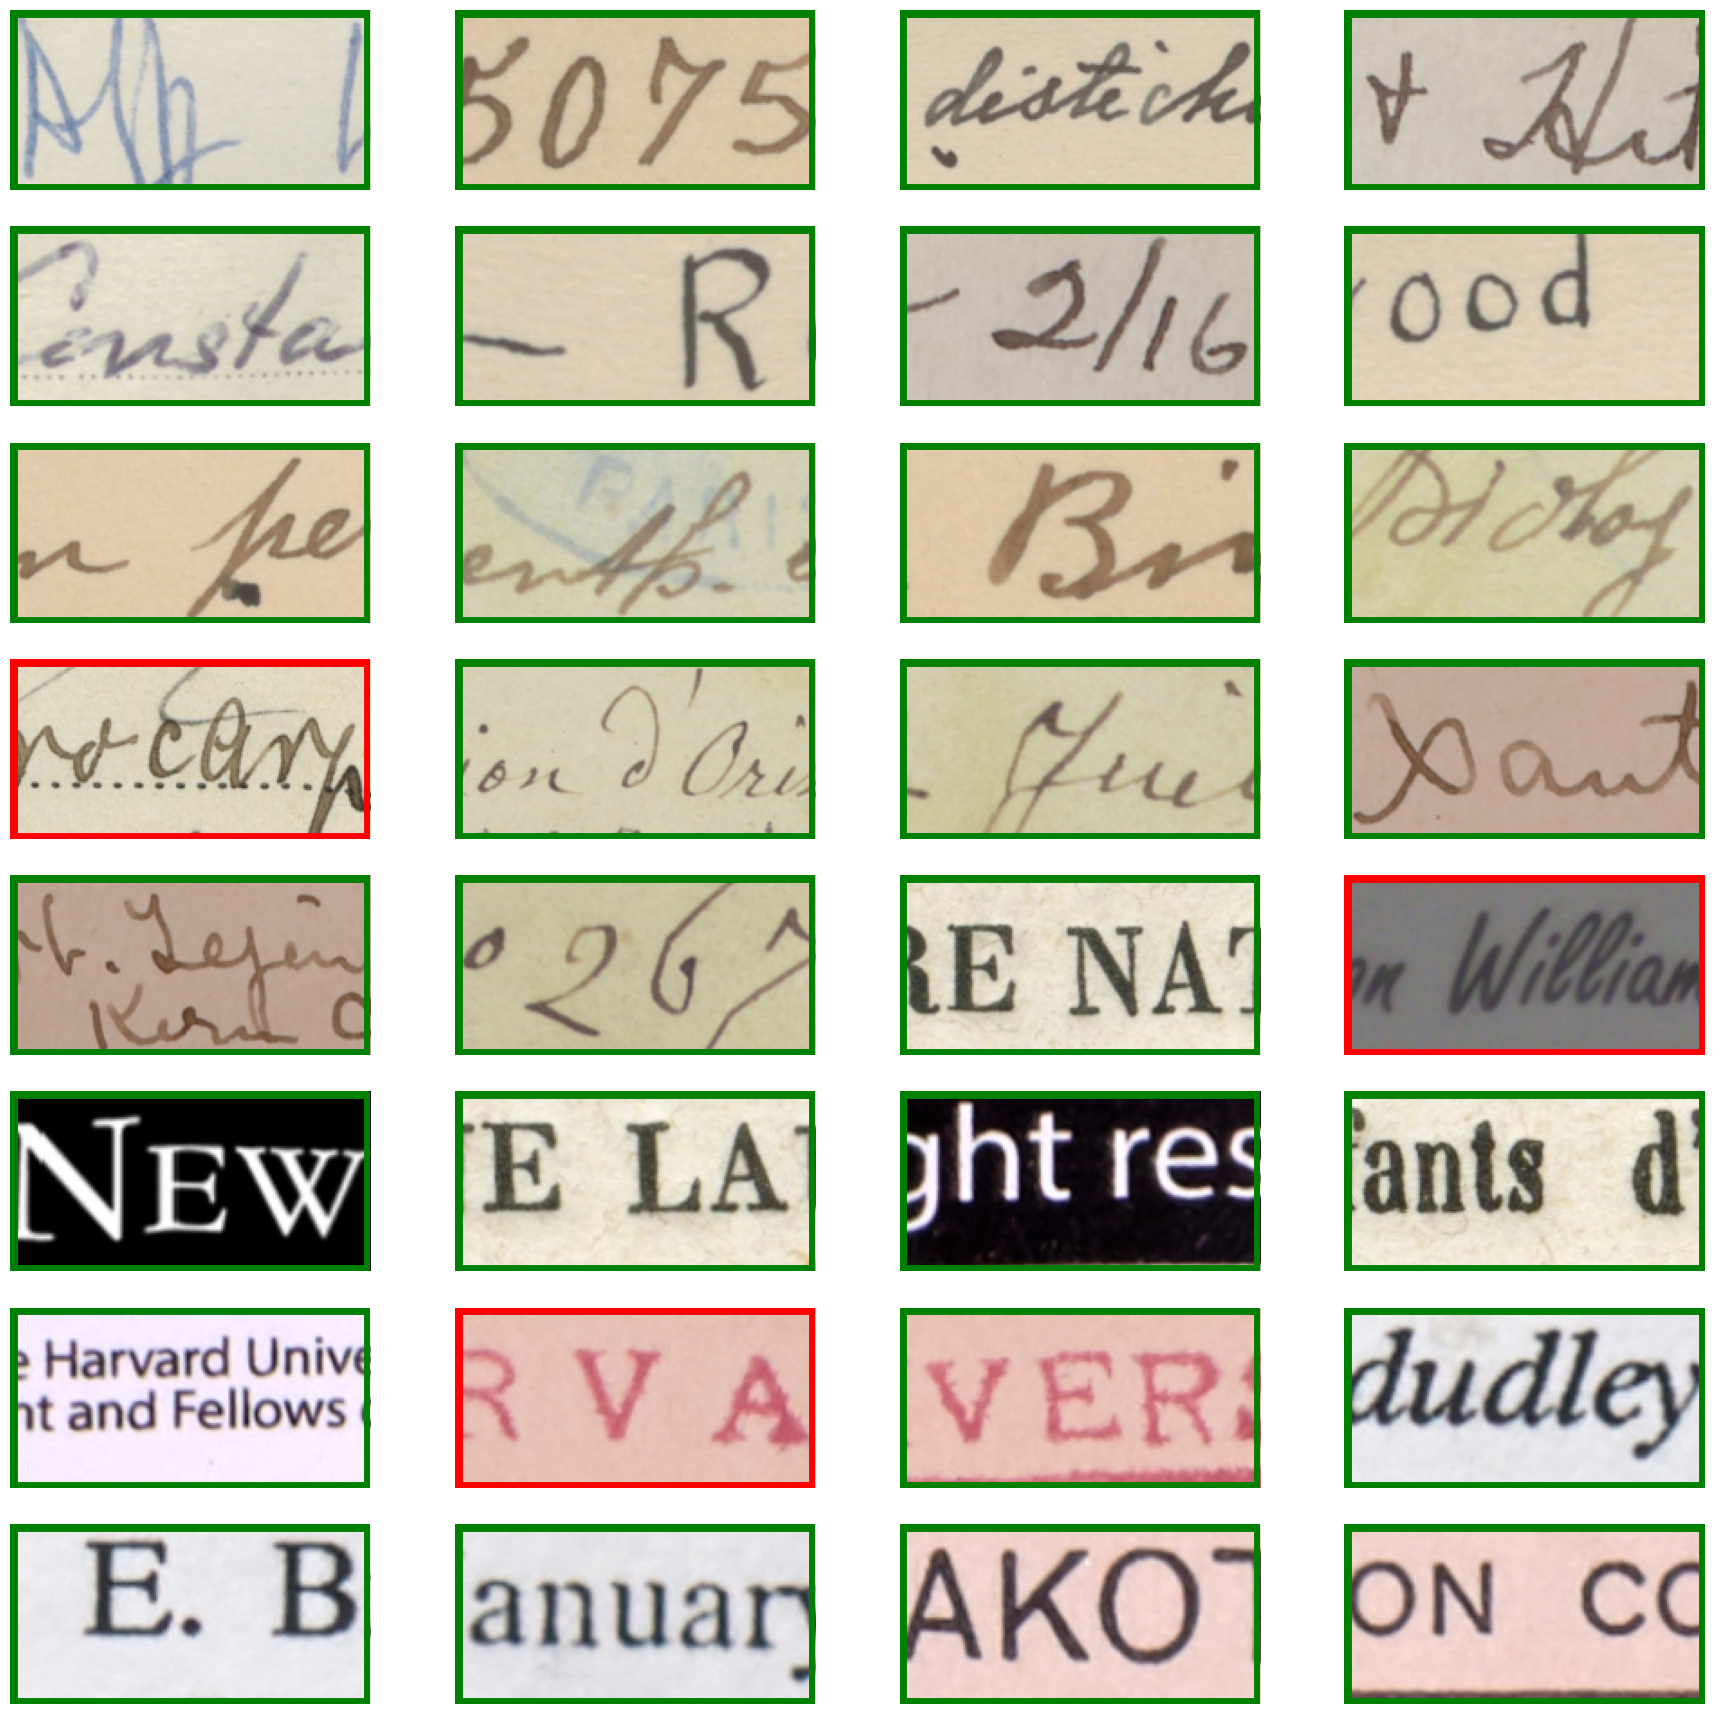

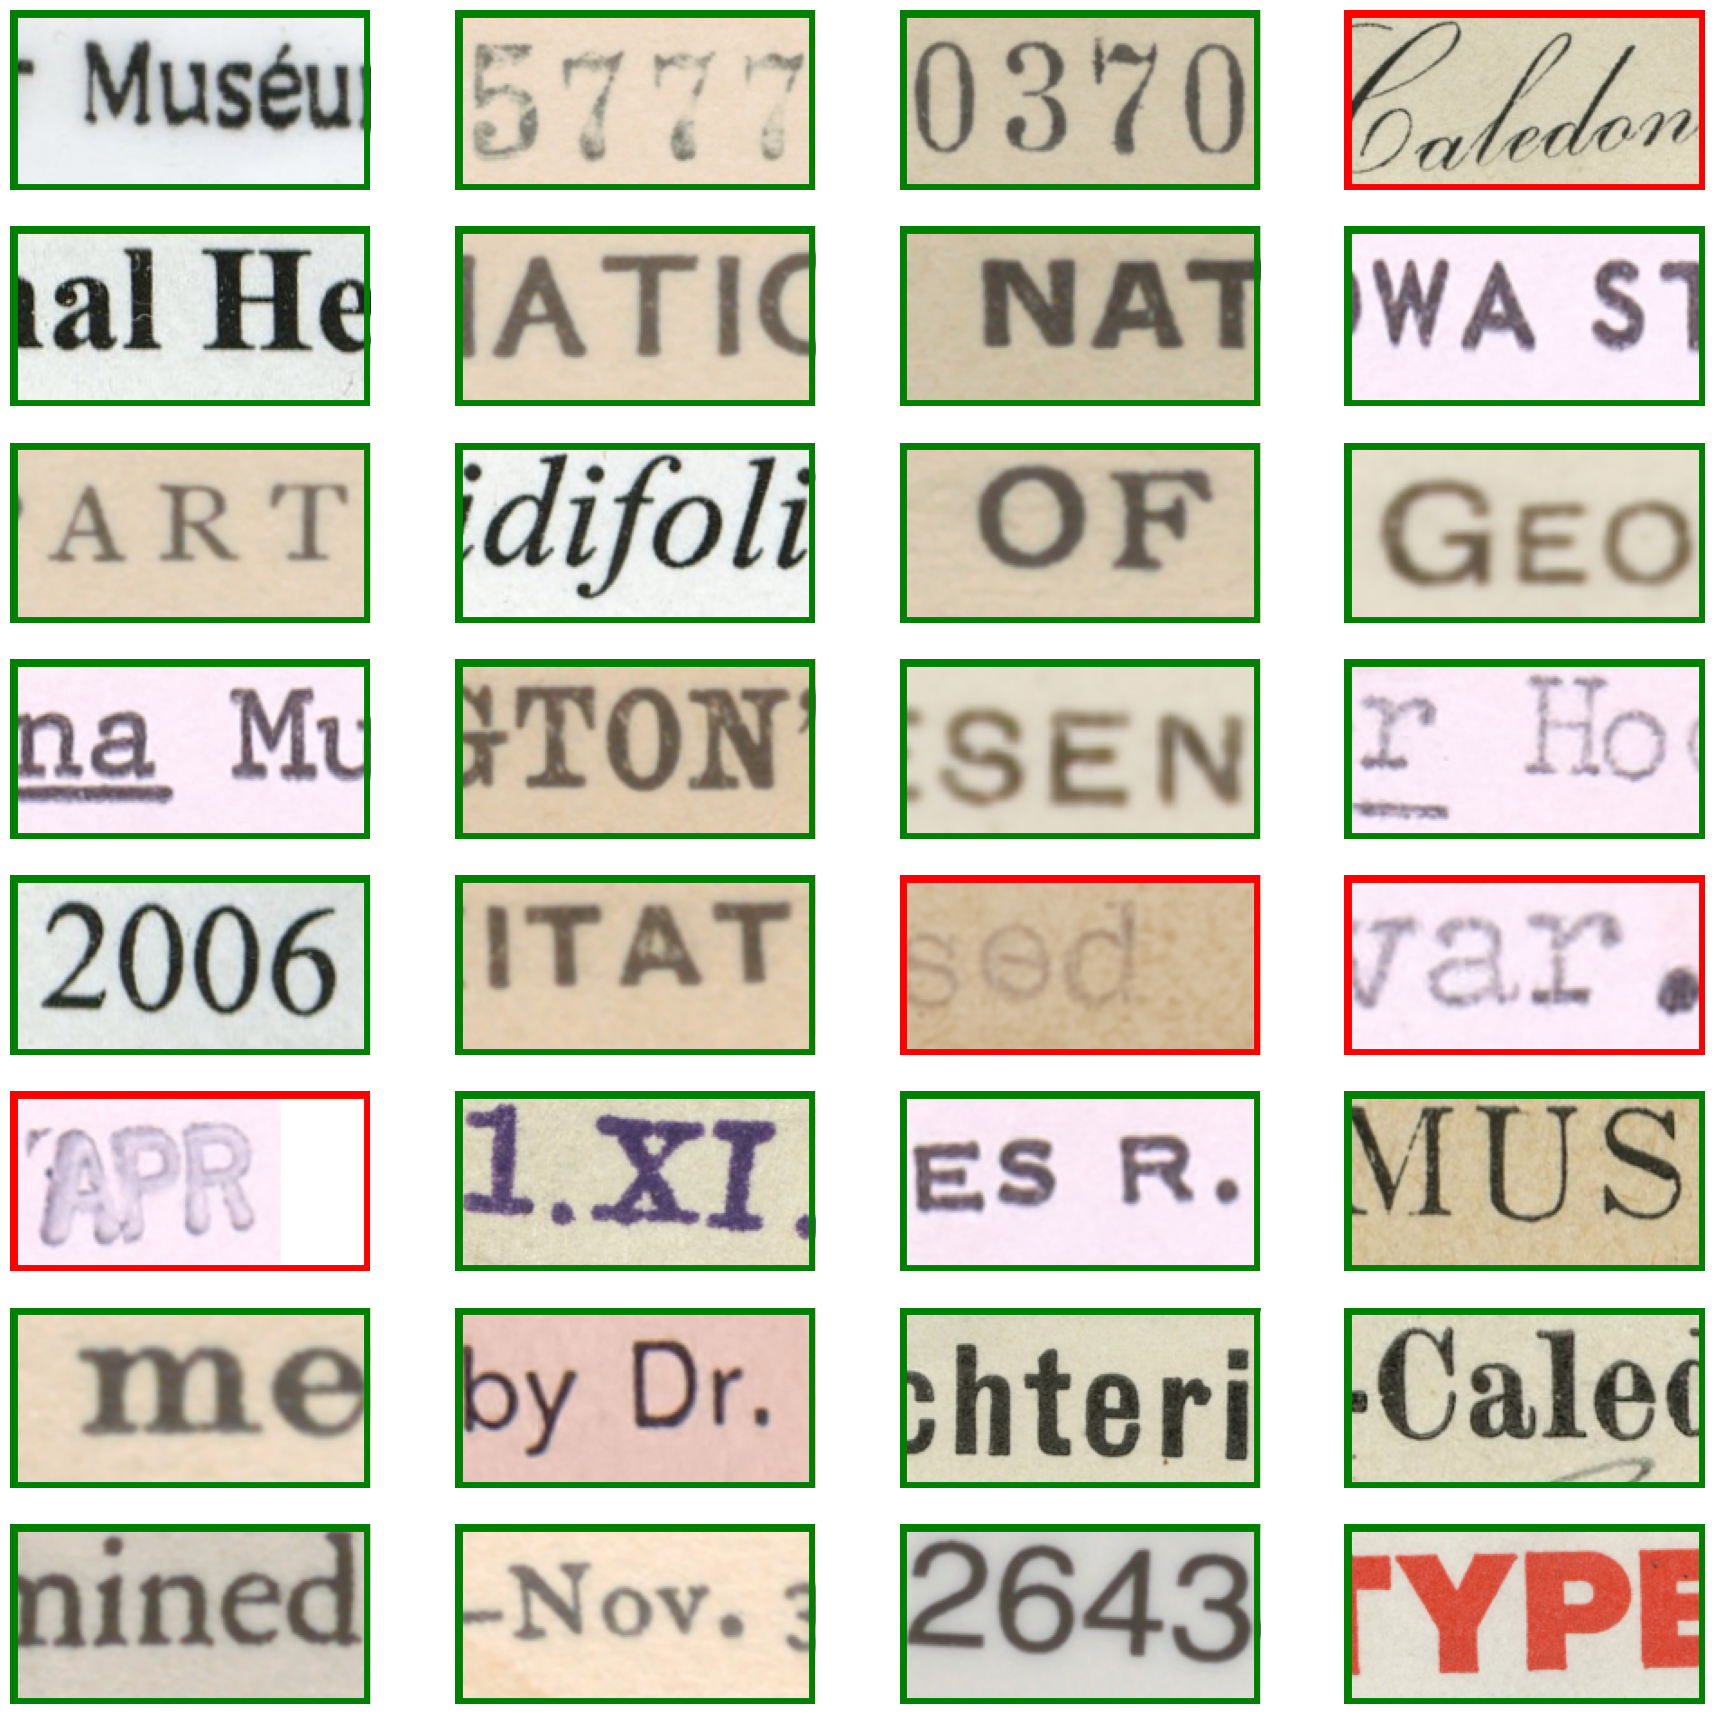

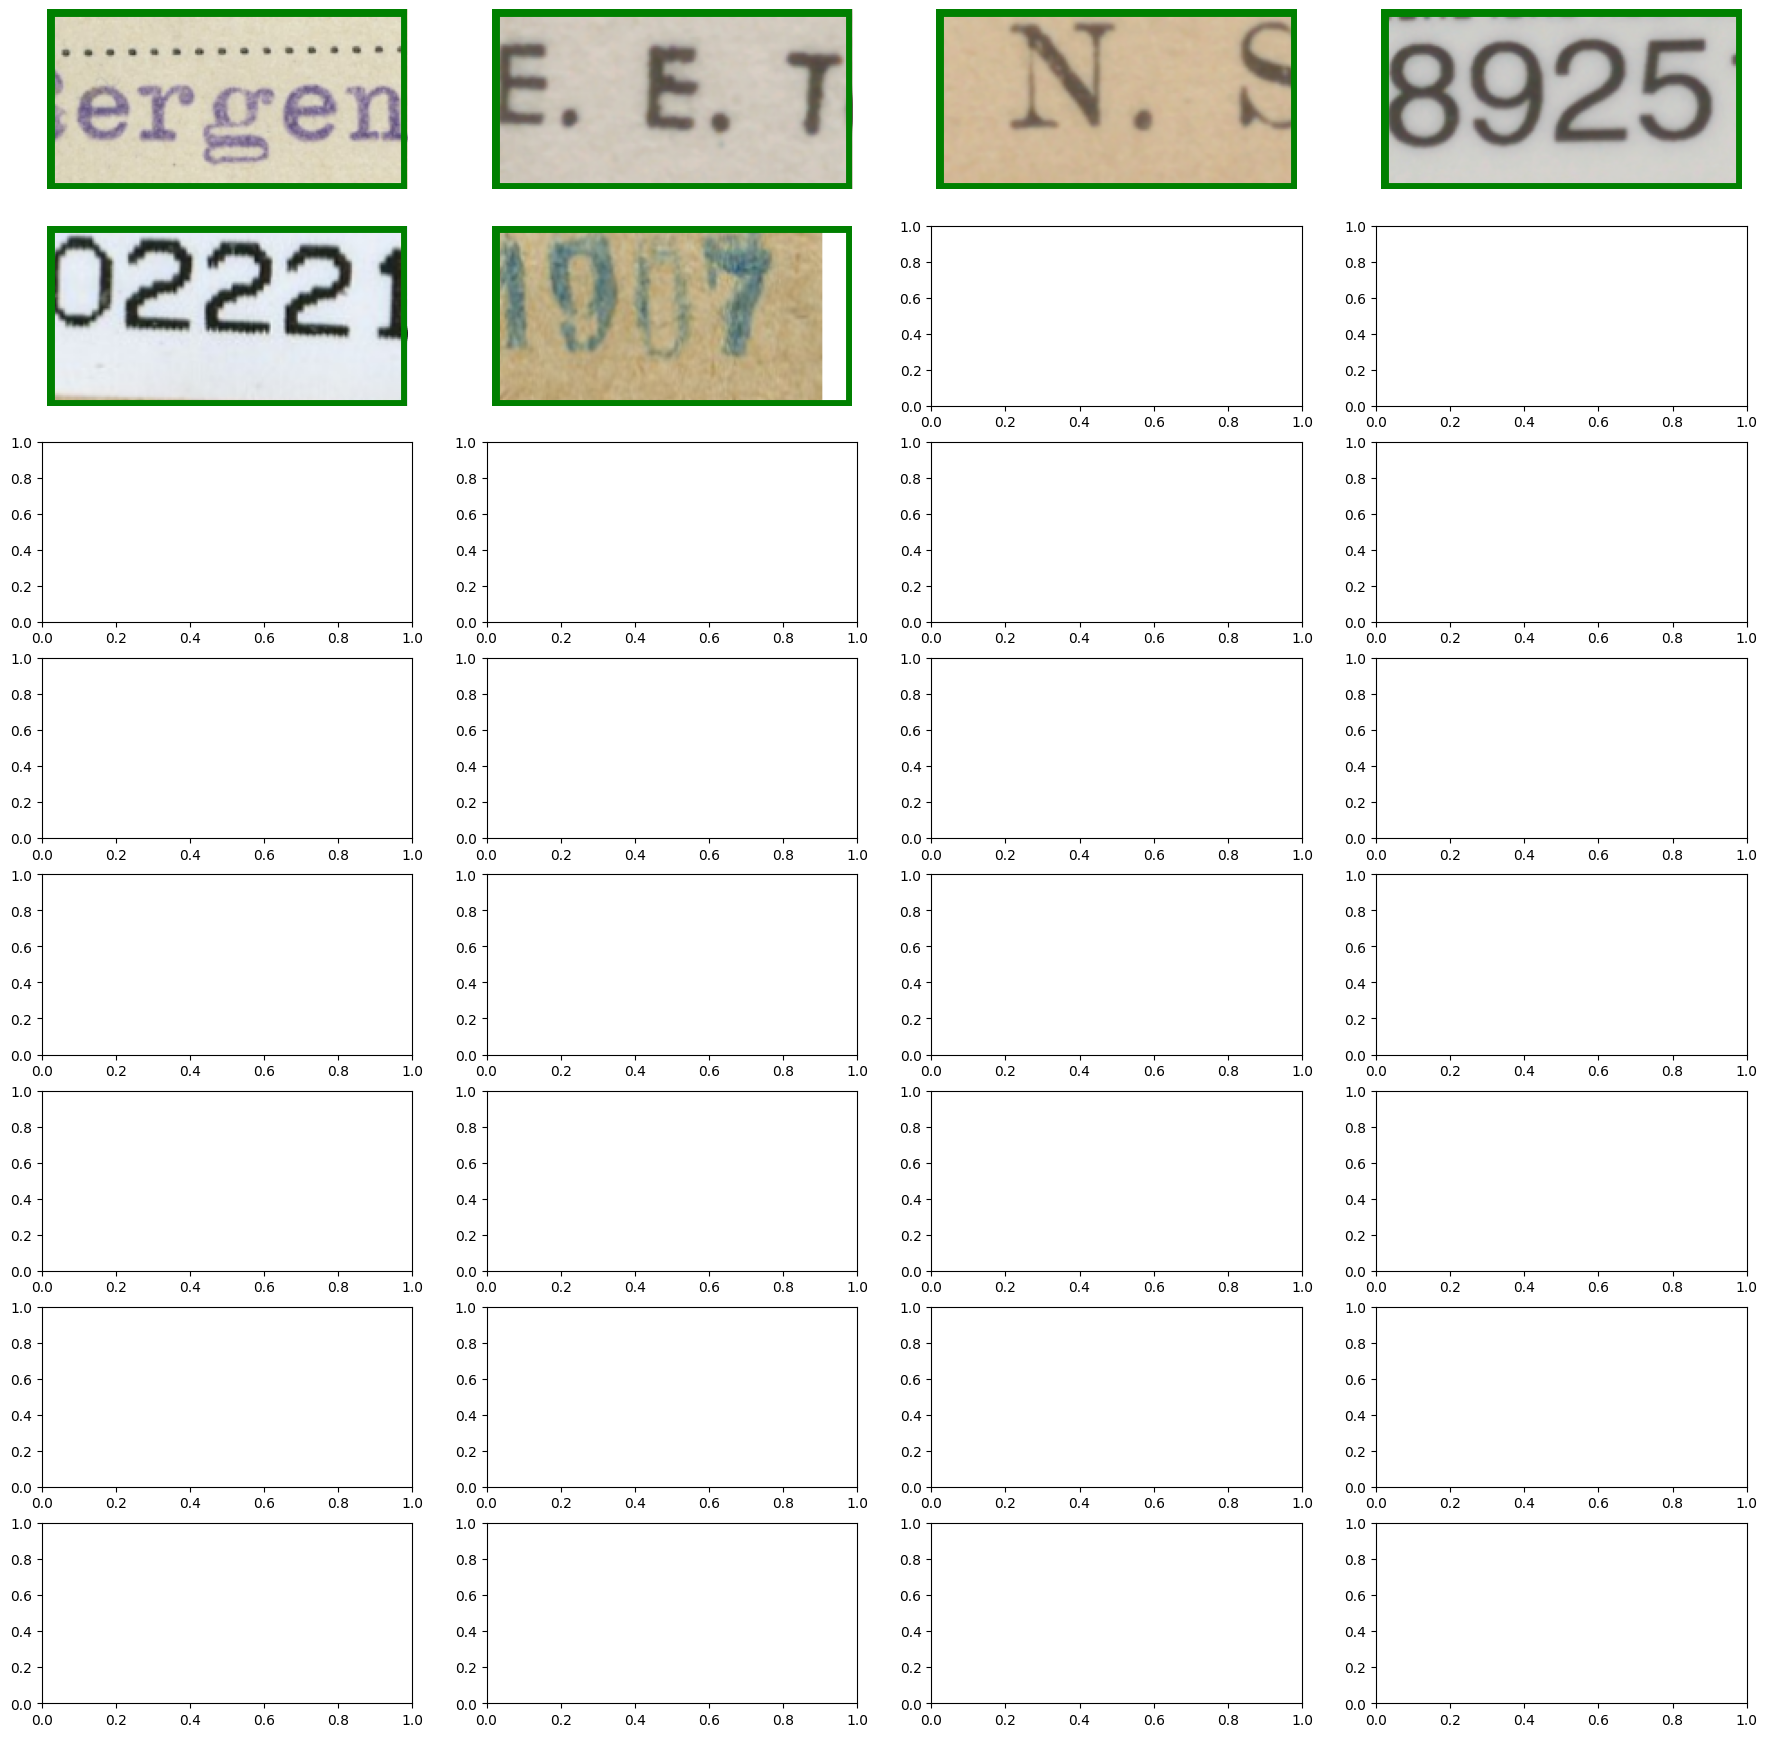

In [19]:
import warnings

test_dataset = ImageFolder(test_data_path, transform=test_preprocess)
test_loader = DataLoader(test_dataset, batch_size=32)

# Disable the warning
warnings.filterwarnings("ignore", category=UserWarning)

img_no = 0

# Iterate over the data loader to get a batch of transformed images
for images, labels in test_loader:
    # Convert images to numpy array and transpose dimensions from 
    # (batch_size, channels, height, width) to (batch_size, height, width, channels)
    images = images.numpy().transpose(0, 2, 3, 1)
        
    num_rows = 8

    # Plot the images
    fig, axes = plt.subplots(num_rows, 4, figsize=(22, 22))
    for i in range(num_rows):
        for j in range(4):
            try:
                axes[i][j].imshow(images[img_no%32])
                axes[i][j].axis('off')
            except IndexError:
                break
            
            edge_color = 'g'
            
            if img_no == len(test_loader.dataset):
                break_flag = True
                break
            if(y_true_cpu[img_no] != y_pred_cpu[img_no]):
                edge_color = 'r'
            
            
            # Create a Rectangle patch
            rect = patches.Rectangle((0, 0), 200, 100, linewidth=10, edgecolor=edge_color, facecolor='none')
            axes[i][j].add_patch(rect)
            img_no += 1
    plt.show()

## Experiments

In [ ]:
# from transformers import ViTFeatureExtractor, ViTForImageClassification

# # Instantiate feature extractor and model
# feature_extractor = ViTFeatureExtractor.from_pretrained('google/vit-base-patch16-224')
# model = ViTForImageClassification.from_pretrained('google/vit-base-patch16-224')

# # Adjust the classifier to match the number of classes
# num_classes = 2  # Assuming you have two classes: handwritten or machine typed
# model.classifier = torch.nn.Linear(model.config.hidden_size, num_classes)

# model = model.to(device)

# # Now you can use this model in your training loop
# for epoch in range(10):  # Adjust as needed
#     for images, labels in train_loader:
        
#         print(inputs)

#         inputs = feature_extractor(images=images, return_tensors="pt")
        
#         inputs, labels = inputs.to(device), labels.to(device)
        
#         print(inputs)
#         outputs = model(**inputs)

#         loss = loss_function(outputs.logits, labels)
        
#         train_loss += loss.item()
#         optimizer.zero_grad()
#         loss.backward()
#         optimizer.step()
        
#     print(f'Train loss at epoch {epoch+1}: {train_loss.item()}')

In [26]:
from transformers import TrOCRProcessor, VisionEncoderDecoderModel
import requests
from PIL import Image

processor = TrOCRProcessor.from_pretrained("microsoft/trocr-base-handwritten")
model = VisionEncoderDecoderModel.from_pretrained("microsoft/trocr-base-handwritten")

Some weights of VisionEncoderDecoderModel were not initialized from the model checkpoint at microsoft/trocr-base-handwritten and are newly initialized: ['encoder.pooler.dense.weight', 'encoder.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [32]:
# load image from the IAM dataset
# url = "https://fki.tic.heia-fr.ch/static/img/a01-122-02.jpg"
# image = Image.open(requests.get(url, stream=True).raw).convert("RGB")

image = Image.open("data/all_preprocessed_data/typed/FUNSD0000971160-10.jpg").convert("RGB")
# image = Image.open("data/all_preprocessed_data/typed/syntheticfile-9_crops-000152.jpg").convert("RGB")

pixel_values = processor(image, return_tensors="pt").pixel_values
generated_ids = model.generate(pixel_values)

generated_text = processor.batch_decode(generated_ids, skip_special_tokens=True)[0]
generated_text

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


'ii'

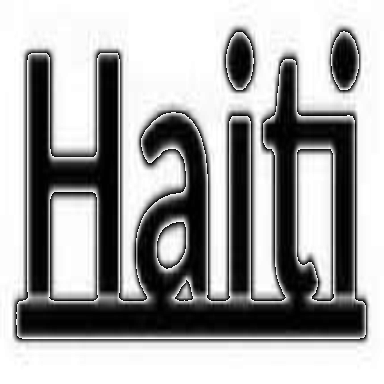

In [21]:
temp_image = transforms.ToPILImage()(pixel_values[0])
temp_image

In [33]:
generated_ids

tensor([[   2, 4132,    2]])

In [11]:
# The `encoder_outputs` variable will contain the intermediate output 
# of the vision transformer part of the TrOCR model
encoder_outputs = model.encoder(pixel_values)

# This is the image representation
image_representation = encoder_outputs.last_hidden_state
image_representation = image_representation.mean(dim=1)  # shape will now be [1, 768]

In [12]:
image_representation

tensor([[ 0.1725, -0.3867, -0.1286,  ...,  0.2052, -0.3625, -0.4994],
        [-0.0924, -0.2957, -0.2853,  ...,  0.6164, -0.2388, -0.2822],
        [ 0.1588, -0.3444, -0.2023,  ...,  0.5765, -0.0988, -0.1870],
        ...,
        [-0.0030, -0.6578,  0.2199,  ...,  0.3897, -0.0497, -0.4029],
        [-0.2889, -0.2004,  0.1602,  ...,  0.5631, -0.2646, -0.0362],
        [ 0.3208, -0.3533,  0.1339,  ...,  0.7275,  0.0027, -0.3574]],
       device='cuda:0')

In [13]:
image_representation.shape

torch.Size([32, 768])